# Jim Haines & Josh McCoy
# Madness of March
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)
### [Project Writeup](https://docs.google.com/document/d/1C9FaOyjY2SxX8GeMs-P5Bh7i4-NTTIAxikybMCfJDcQ/edit?usp=sharing)
### [Pitch Slide](https://docs.google.com/presentation/d/1rfwEKVtp47pwfxAcYXfq9TbwZCgx3hwdcOnqeyRasVI/edit?usp=sharing)

## Collaboration Plan

For this project, we decided to setup a private Github repository to allow for collaboration. We plan to work together whenever possible, but we are also capabale of working independently of each other as long as we communicate and our work is well documented. We aim to meet multiple times a week to work on our project, but we can meet more often if necessary. We plan on using libraries like matplotlib and seaborn, we have used both of these already, and more in out final tutorial to make meaningful visualizations. In all, we hope to be able to work with each other and outside sources to determine the best model to predict March Maddnes Tournament winners.

## Project overview and our goals

The main goal of our project is to outperform other competitors in the March Machine Learning Mania 2023 Kaggle competition. The goal of this competition is to create a model that can most accurately and confidently identify the winner of each game in the men's and women's NCAA basketball tournament. We also aim to eventually provide an interactive dashboard that will allow users to choose their own factors to see if they can outperform our design. This is a process that we would complete after participating in the competition.

Since the data for the 2023 March Maddness competition has not yet been released, we are doing our ETL on data from the 2022 competition. Although there are some changes from 2022 (Brier score, combining men's and women's competition) the main process of ETL should be similar enough that it is valubale to us. Below we have included links to 3 previos competitions. 

[2019 Competition](https://www.kaggle.com/competitions/mens-machine-learning-competition-2019)

[2021 Competition](https://www.kaggle.com/competitions/ncaam-march-mania-2021)

[2022 Competition](https://www.kaggle.com/competitions/mens-march-mania-2022)

## Step 1: ETL

In [49]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [22]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

In [23]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

All the dtypes look correct, so lets move on to our analysis

In [24]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [25]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %

detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [26]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']

detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

In [27]:
# Create correlation graph to see how each feature affects the winning score difference

# plt.rc('figure', figsize=(10, 5))
# tmp = detailed_results[(detailed_results['SCOREDIFF']>6)&(detailed_results['NumOT']==0)]
# tmp = tmp.apply(pd.to_numeric, errors='coerce')
# corr = tmp.corr()
# corr = corr[corr.index.isin(['SCOREDIFF'])]
# sns.heatmap(corr[['WFGPCT', 'W3PCT', 'WFTPCT', 'WORPCT', 'LFGPCT', 'L3PCT', 
#                   'LFTPCT', 'LORPCT']], annot=True)

We can see that the winning teams field goal % correlates strongly with the winning score difference. This makes sense as basically, the higher your field goal %, the more likely you are to win. Contrastly, we can see that winners free throw % is not as important in predicting by how much a team will win. 

We can now take a more detailed look at the correlation between winner field goal % and score difference.

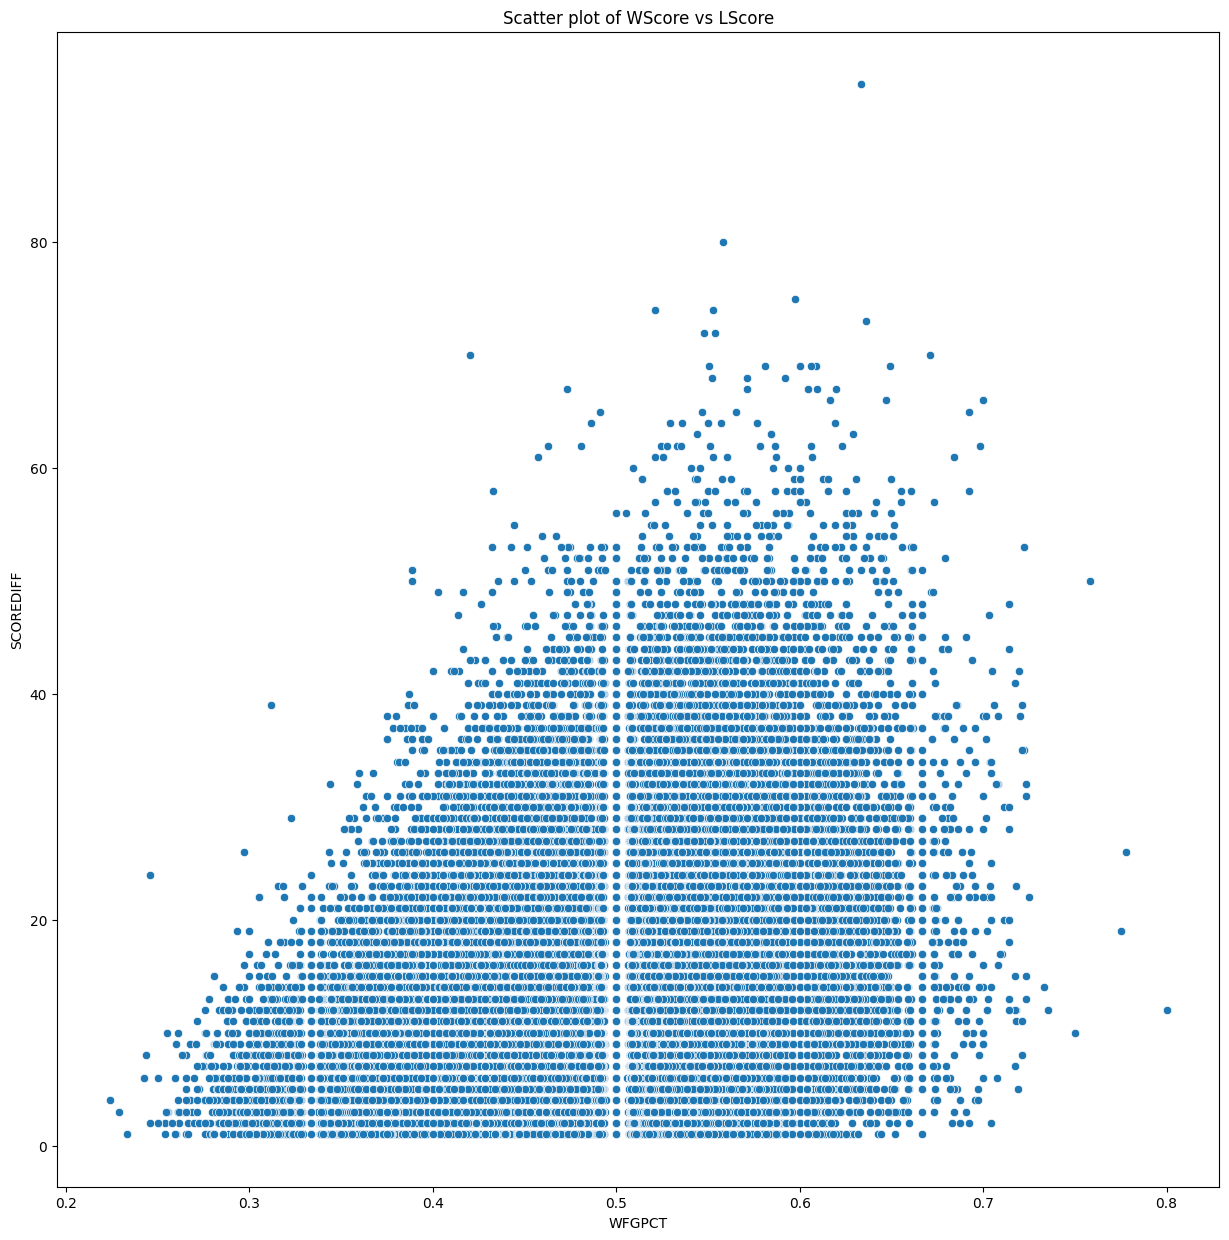

In [28]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WFGPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)

plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WFGPCT')
plt.ylabel('SCOREDIFF')
plt.show()

We can look at other factors as well:

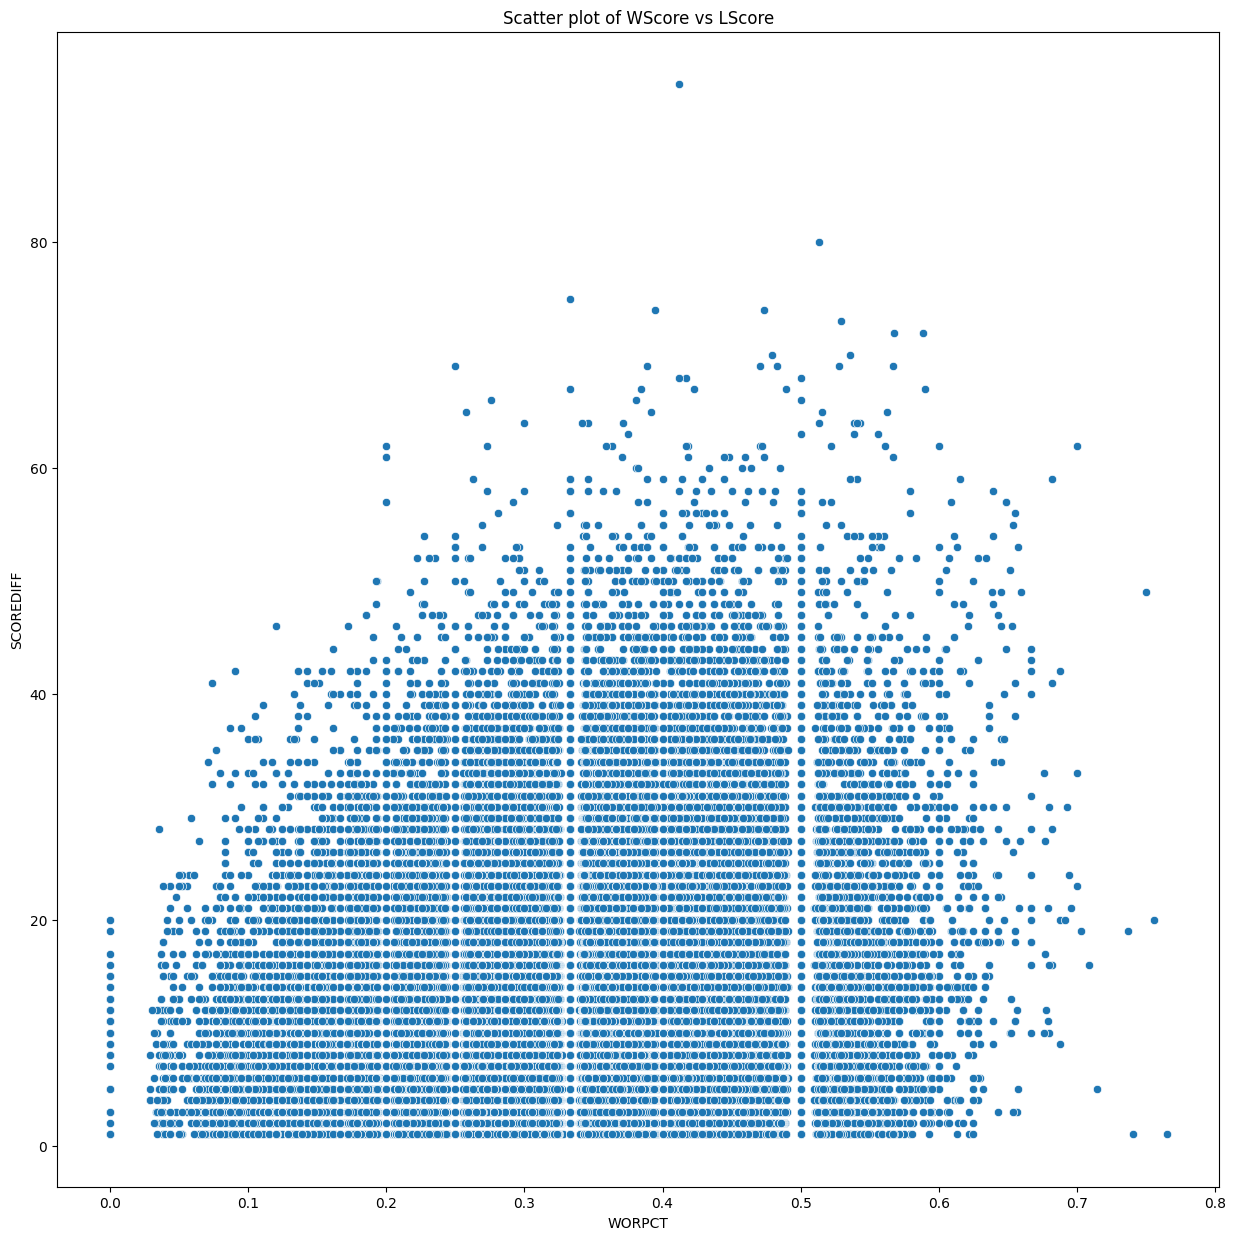

In [29]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WORPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)

plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WORPCT')
plt.ylabel('SCOREDIFF')
plt.show()

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

In [30]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,15,14,19,7,20,9,9,7,0,13
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,6,11,8,24,12,14,5,3,11
1178,2021,152,1124,78,1222,59,N,0,29,55,...,19,11,16,13,12,10,10,4,5,10
1179,2021,152,1211,93,1417,90,N,1,37,63,...,17,14,21,7,24,21,9,4,1,16


In [31]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [32]:
# Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [33]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %

detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [34]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']

detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [35]:
# Create correlation graph to see how each feature affects the winning score difference

# plt.rc('figure', figsize=(10, 5))
# tmp = detailed_tourney_results[(detailed_tourney_results['SCOREDIFF']>6)&(detailed_tourney_results['NumOT']==0)]
# tmp = tmp.apply(pd.to_numeric, errors='coerce')
# corr = tmp.corr()
# corr = corr[corr.index.isin(['SCOREDIFF'])]
# sns.heatmap(corr[['WFGPCT', 'W3PCT', 'WFTPCT', 'WORPCT', 'LFGPCT', 'L3PCT', 
#                   'LFTPCT', 'LORPCT']], annot=True)

From this analysis we can see that the correlations from regualar season and those from the tournament are very similar. This is something we would expect, but we hope to identify some features that are more indicative of a teams performance in the tournament as opposed to the regular season.

# Questions We Plan to Explore

Data Exploration & Visualization:
How are the teams distributed by region, conference, or seeding?
Can we visualize the historical performance of teams in the tournament?
What are the most common upset scenarios based on historical data?

Feature Engineering:
Which features are the most predictive of a team's success in the tournament?
Can we generate new features based on team stats, like offensive/defensive efficiency, to improve model performance?
How can we incorporate player-specific data or injuries into our model?

Model Selection & Evaluation:
Which algorithms perform best for this prediction task? Logistic regression? Random forests? Gradient boosted trees?
How do different algorithms handle the class imbalance inherent in a tournament bracket?
How do we measure the performance of our model? Accuracy? Log-loss?

Game Theory and Strategy:
How can we optimize our bracket for a specific competition scoring system?
What are the strategies for differentiating our predictions in large pools to maximize the chance of winning?

# Next Steps 

1. Explore Kaggle Datasets:
Dive deeper into the Detailed Games CSV.
Conduct exploratory data analysis (EDA) to understand the data better.
Identify and address missing or inconsistent data.
Refine research questions based on initial insights.
2. Incorporate External Data:
Find reliable sources for high school rankings and player ages.
Develop web scraping scripts to gather this data.
Clean and align scraped data with Kaggle datasets.
Merge the new data with existing datasets using common identifiers.
3. Data Integration and Transformation:
Ensure data compatibility between sources.
Handle data conflicts or discrepancies.
Calculate summary statistics or create relevant features.
Prepare data for specific analyses.
4. EDA 
Revisit EDA with the enriched dataset.
Visualize relationships and patterns.
Adjust research questions based on new insights.
5. Model Development:
Choose appropriate modeling techniques.
Split data into training and testing sets.
Develop and refine models.
Evaluate model performance.
6. Documentation and Reporting:
Maintain detailed records and organized GitHub repository.
Create clear visualizations and summaries.
Communicate findings effectively.


In [36]:
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,0.500000,0.333333,0.705882,31,0.354839,0.387097,0.266667,0.736842,34,0.205882
1177,2021,148,1417,51,1276,49,N,0,21,54,...,0.388889,0.230769,0.857143,30,0.200000,0.392157,0.272727,0.545455,29,0.275862
1178,2021,152,1124,78,1222,59,N,0,29,55,...,0.527273,0.458333,0.692308,23,0.478261,0.381818,0.315789,0.687500,30,0.433333
1179,2021,152,1211,93,1417,90,N,1,37,63,...,0.587302,0.333333,0.600000,28,0.142857,0.576271,0.470588,0.666667,26,0.269231


# MODEL TESTING

In [37]:
# Add Outcome column in indicate win (1) or loss (0)
wins_df = detailed_tourney_results.copy()
losses_df = detailed_tourney_results.copy()

wins_df['Outcome'] = 1
losses_df['Outcome'] = 0

# Rename team and score columns for clarity
wins_df.rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'}, inplace=True)
losses_df.rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'}, inplace=True)

# Concatenate the dfs, now each game is represented twice, once for each team
outcome_df = pd.concat([wins_df, losses_df], ignore_index=True)

# Drop location value as we will use other datasets for this
outcome_df = outcome_df.drop(['WLoc'], axis=1)

In [38]:
outcome_df.dtypes
outcome_df

,Season,DayNum,TeamID,Score,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,...,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,Outcome,WTeamID,WScore
0,2003,134,1421,92,1411.0,84.0,1,32,69,11,...,42,0.333333,0.432836,0.387097,0.451613,47,0.361702,1,NaN,NaN
1,2003,136,1112,80,1436.0,51.0,0,31,66,7,...,37,0.297297,0.312500,0.250000,1.000000,44,0.181818,1,NaN,NaN
2,2003,136,1113,84,1272.0,71.0,0,31,59,6,...,32,0.312500,0.362319,0.250000,0.666667,47,0.425532,1,NaN,NaN
3,2003,136,1141,79,1166.0,73.0,0,29,53,3,...,28,0.392857,0.450000,0.411765,0.705882,34,0.411765,1,NaN,NaN
4,2003,136,1143,76,1301.0,74.0,1,27,64,7,...,44,0.409091,0.446429,0.428571,0.750000,30,0.333333,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,148,1425,66,NaN,NaN,0,33,66,7,...,31,0.354839,0.387097,0.266667,0.736842,34,0.205882,0,1211.0,85.0
2358,2021,148,1276,49,NaN,NaN,0,21,54,3,...,30,0.200000,0.392157,0.272727,0.545455,29,0.275862,0,1417.0,51.0
2359,2021,152,1222,59,NaN,NaN,0,29,55,11,...,23,0.478261,0.381818,0.315789,0.687500,30,0.433333,0,1124.0,78.0
2360,2021,152,1417,90,NaN,NaN,1,37,63,7,...,28,0.142857,0.576271,0.470588,0.666667,26,0.269231,0,1211.0,93.0


In [39]:
season_2003_data = outcome_df[outcome_df["Season"] == 2003]
season_2003_data['Outcome'].value_counts()

Outcome
1    64
0    64
Name: count, dtype: int64

In [44]:
# List to keep track of scores and number of games for each season
season_scores = []

# Iterate through each season
for season in range(2003, 2022):
    season_data = outcome_df[outcome_df['Season'] == season]
    
    # Check if there is data for this season
    if season_data.empty:
        print(f"No data available for season {season}. Skipping...")
        continue  # Skip to the next iteration of the loop
    
    features = ['Score', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT', 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT']
    X = season_data[features]
    y = season_data['Outcome']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the logistic regression model
    log_reg = LogisticRegression()
    
    log_reg.fit(X_train_scaled, y_train)
    
    y_pred = log_reg.predict(X_test_scaled)
    
    # Calculate and store the scores and number of games for this season
    num_games = X_test.shape[0]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
    
    # Calculate Brier score
    brier_score = brier_score_loss(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
    
    # Append the scores and number of games for this season, including Brier score
    season_scores.append((season, num_games, accuracy, precision, recall, f1, roc_auc, brier_score))

# Convert the scores to a DataFrame for easier viewing
log_reg_score_df = pd.DataFrame(season_scores, columns=['Season', 'Number of Games', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Brier Score'])

# Now, log_reg_score_df should have one row per season, with the Brier score included
log_reg_score_df



No data available for season 2020. Skipping...


,Season,Number of Games,Accuracy,Precision,Recall,F1 Score,ROC AUC,Brier Score
0,2003,26,0.769231,0.888889,0.615385,0.727273,0.846154,0.157991
1,2004,26,0.884615,1.000000,0.769231,0.869565,0.923077,0.120528
2,2005,26,0.923077,0.923077,0.923077,0.923077,0.958580,0.101723
3,2006,26,0.807692,1.000000,0.615385,0.761905,0.970414,0.122759
4,2007,26,0.807692,0.785714,0.846154,0.814815,0.928994,0.125164
5,2008,26,0.769231,0.818182,0.692308,0.750000,0.816568,0.171374
6,2009,26,0.923077,1.000000,0.846154,0.916667,0.928994,0.103581
7,2010,26,0.769231,0.818182,0.692308,0.750000,0.840237,0.165290
8,2011,27,0.777778,0.923077,0.705882,0.800000,0.835294,0.186956
9,2012,27,0.814815,1.000000,0.705882,0.827586,0.952941,0.117523


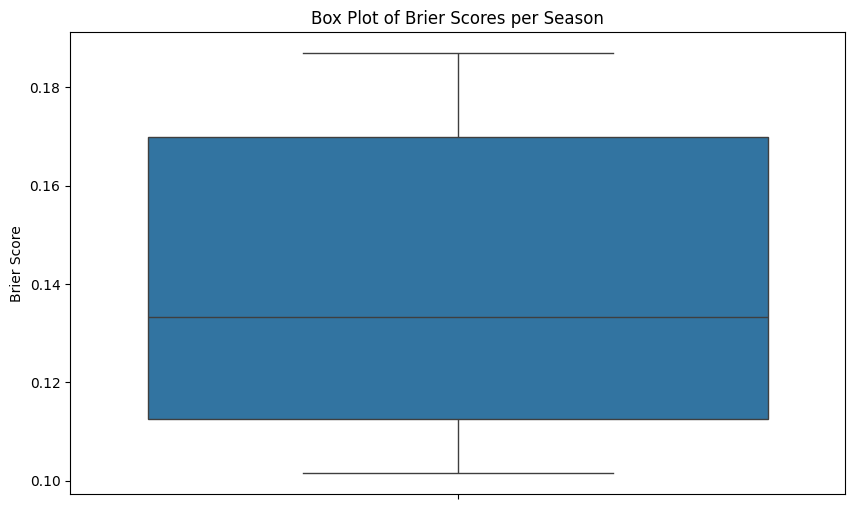

In [45]:
# Use the 'Brier Score' column from log_reg_score_df instead of brier_score_df
plt.figure(figsize=(10, 6))
sns.boxplot(y='Brier Score', data=log_reg_score_df)  # Updated data argument to log_reg_score_df
plt.title('Box Plot of Brier Scores per Season')
plt.show()


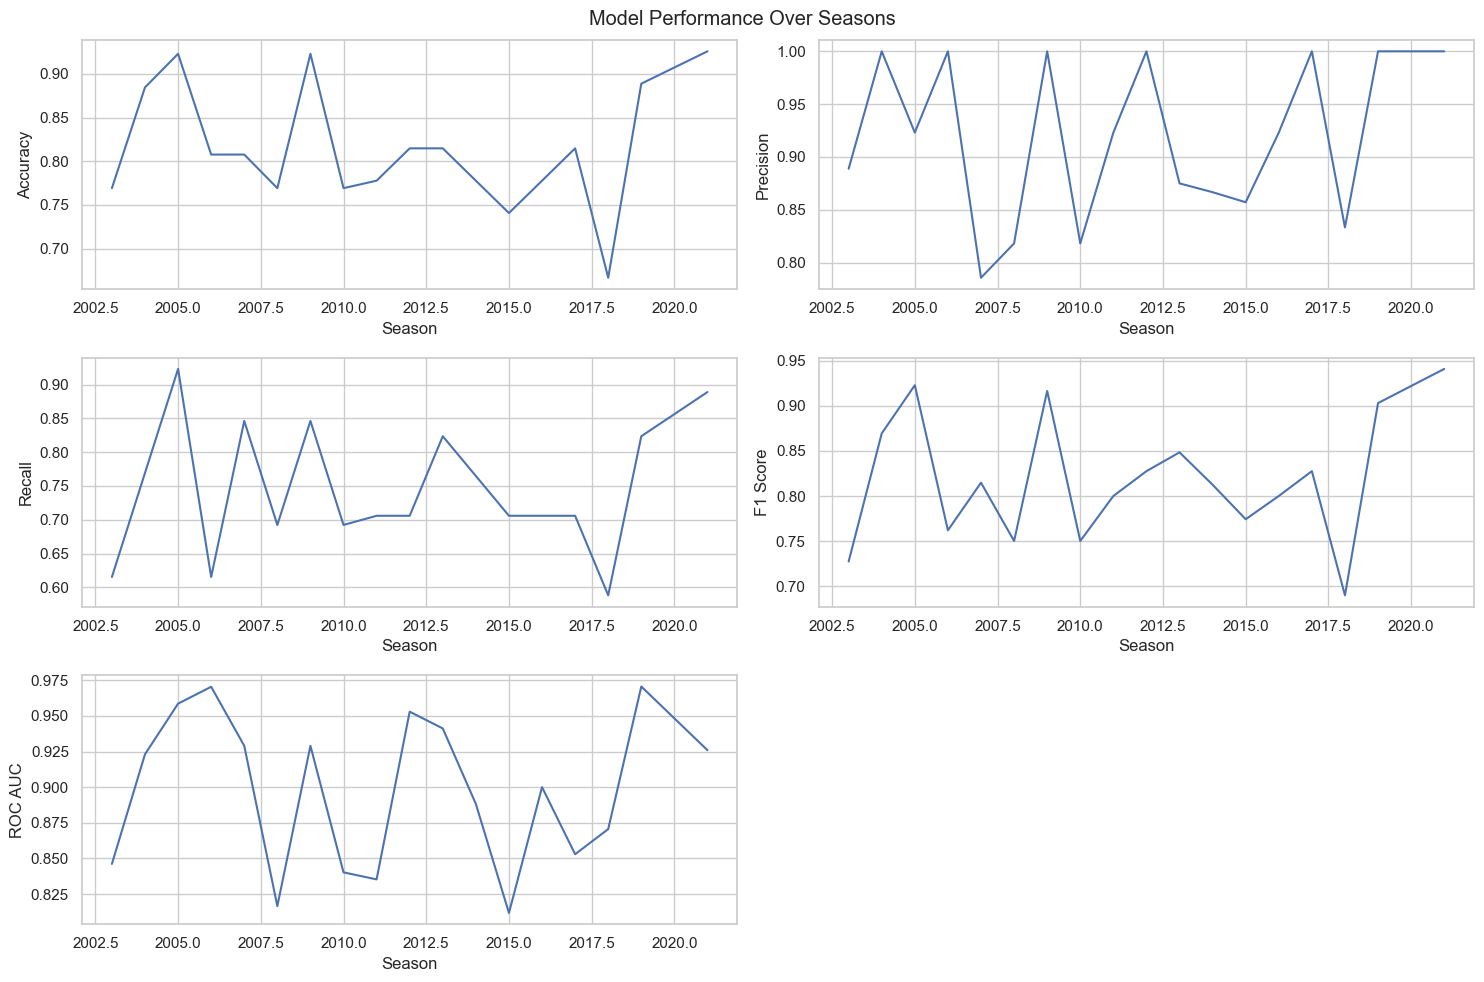

In [46]:
sns.set(style="whitegrid")

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Model Performance Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Accuracy', data=log_reg_score_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=log_reg_score_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=log_reg_score_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=log_reg_score_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=log_reg_score_df, ax=axes[2, 0])

axes[2, 1].axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust title position
plt.show()


# Linear Regression

In [50]:
# List to keep track of error metrics for each season
error_metrics = []

# Iterate through each season
for season in range(2003, 2022):
    # Filter the data for the current season
    season_data = outcome_df[outcome_df['Season'] == season]
    
    # Check if there is data for this season
    if season_data.empty:
        print(f"No data available for season {season}. Skipping...")
        continue  # Skip to the next iteration of the loop
    
    # Select features and target variable
    features = ['Score', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT', 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT']
    X = season_data[features]
    y = season_data['Outcome']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the linear regression model
    lin_reg = LinearRegression()
    
    # Fit the model to the training data
    lin_reg.fit(X_train_scaled, y_train)
    
    # Predict the outcomes on the testing data
    y_pred = lin_reg.predict(X_test_scaled)
    
    # Since linear regression might produce predictions outside [0,1], clip them
    y_pred_clipped = y_pred.clip(0, 1)
    
    # Calculate error metrics and append to list
    brier_score = brier_score_loss(y_test, y_pred_clipped)
    mae = mean_absolute_error(y_test, y_pred_clipped)
    mse = mean_squared_error(y_test, y_pred_clipped)
    r2 = r2_score(y_test, y_pred_clipped)
    
    error_metrics.append((season, brier_score, mae, mse, r2))

# Convert to a DataFrame for easier viewing
error_metrics_df = pd.DataFrame(error_metrics, columns=['Season', 'Brier Score', 'Mean Absolute Error', 'Mean Squared Error', 'R-squared'])

error_metrics_df

 



No data available for season 2020. Skipping...


,Season,Brier Score,Mean Absolute Error,Mean Squared Error,R-squared
0,2003,0.162313,0.305951,0.162313,0.350746
1,2004,0.107393,0.252665,0.107393,0.570429
2,2005,0.091999,0.227499,0.091999,0.632006
3,2006,0.119443,0.247861,0.119443,0.522229
4,2007,0.137151,0.315560,0.137151,0.451396
5,2008,0.177245,0.320602,0.177245,0.291020
6,2009,0.117792,0.290673,0.117792,0.528833
7,2010,0.174008,0.295272,0.174008,0.303969
8,2011,0.167286,0.353511,0.167286,0.282639
9,2012,0.106495,0.239423,0.106495,0.543325


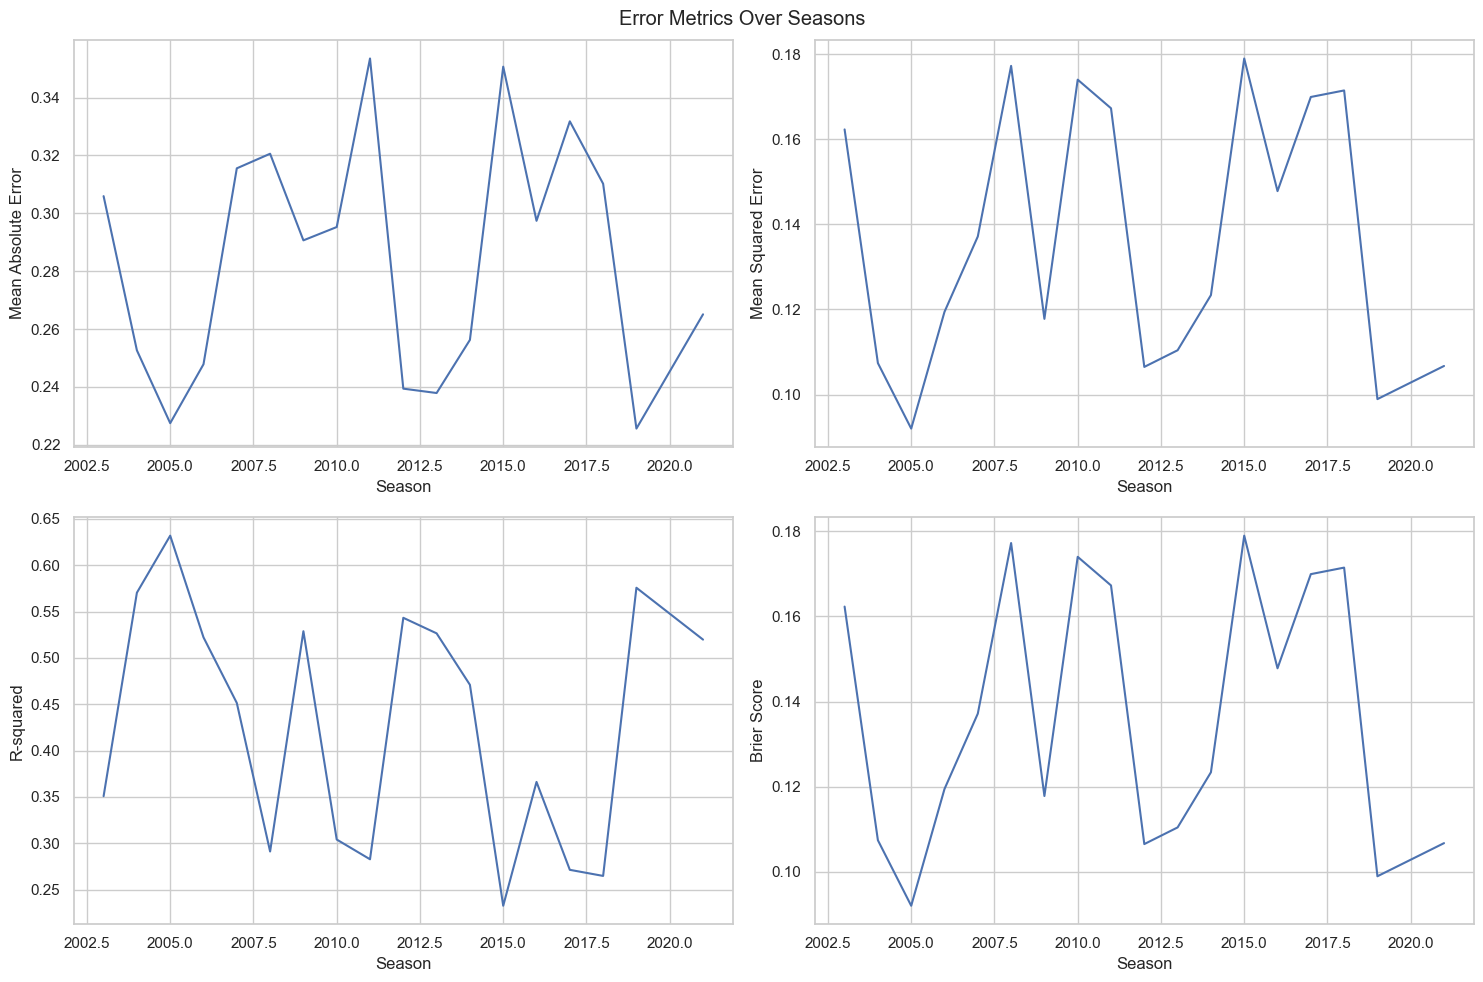

In [51]:
# Set style for seaborn
sns.set(style="whitegrid")

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Error Metrics Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Mean Absolute Error', data=error_metrics_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Mean Squared Error', data=error_metrics_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='R-squared', data=error_metrics_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='Brier Score', data=error_metrics_df, ax=axes[1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust title position
plt.show()


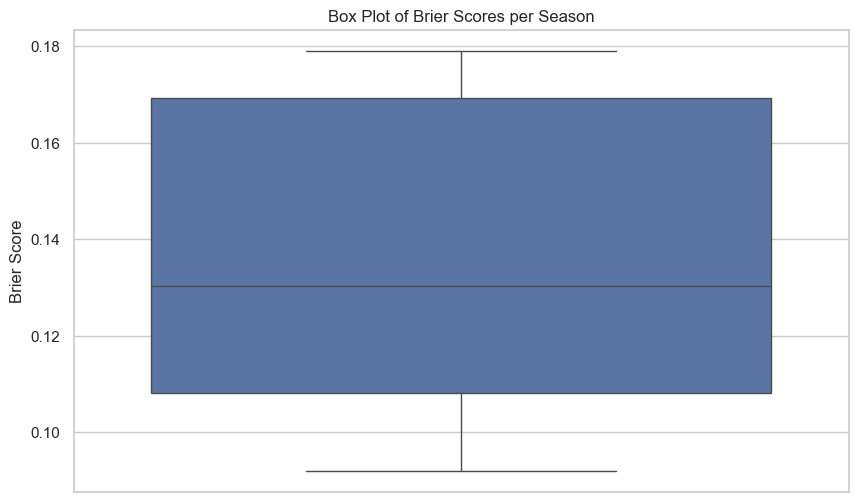

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='Brier Score', data=error_metrics_df)
plt.title('Box Plot of Brier Scores per Season')
plt.show()


# XGBoost

In [53]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume outcome_df is your data

# List to keep track of scores for each season
season_scores = []

# Iterate through each season
for season in range(2003, 2022):
    # Filter the data for the current season
    season_data = outcome_df[outcome_df['Season'] == season]
    
    # Check if there is data for this season
    if season_data.empty:
        print(f"No data available for season {season}. Skipping...")
        continue  # Skip to the next iteration of the loop
    
    # Select features and target variable
    features = ['Score', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT', 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT']
    X = season_data[features]
    y = season_data['Outcome']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # Fit the model to the training data
    xgb_model.fit(X_train_scaled, y_train)
    
    # Predict the outcomes on the testing data
    y_pred = xgb_model.predict(X_test_scaled)
    
    # Calculate and store the scores for this season
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
    
    # Calculate Brier score
    brier_score = brier_score_loss(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
    
    # Append the scores and Brier score for this season
    season_scores.append((season, accuracy, precision, recall, f1, roc_auc, brier_score))

# Convert the scores to a DataFrame for easier viewing
xgb_score_df = pd.DataFrame(season_scores, columns=['Season', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Brier Score'])

# Now, xgb_score_df should have one row per season, with the Brier score included
xgb_score_df


No data available for season 2020. Skipping...


,Season,Accuracy,Precision,Recall,F1 Score,ROC AUC,Brier Score
0,2003,0.538462,0.545455,0.461538,0.500000,0.553254,0.365737
1,2004,0.730769,0.714286,0.769231,0.740741,0.757396,0.245741
2,2005,0.538462,0.529412,0.692308,0.600000,0.639053,0.346016
3,2006,0.615385,0.636364,0.538462,0.583333,0.520710,0.365169
4,2007,0.538462,0.533333,0.615385,0.571429,0.562130,0.338273
5,2008,0.692308,0.777778,0.538462,0.636364,0.656805,0.282429
6,2009,0.692308,0.727273,0.615385,0.666667,0.692308,0.272218
7,2010,0.653846,0.700000,0.538462,0.608696,0.644970,0.306875
8,2011,0.555556,0.727273,0.470588,0.571429,0.670588,0.346911
9,2012,0.740741,0.857143,0.705882,0.774194,0.805882,0.215940


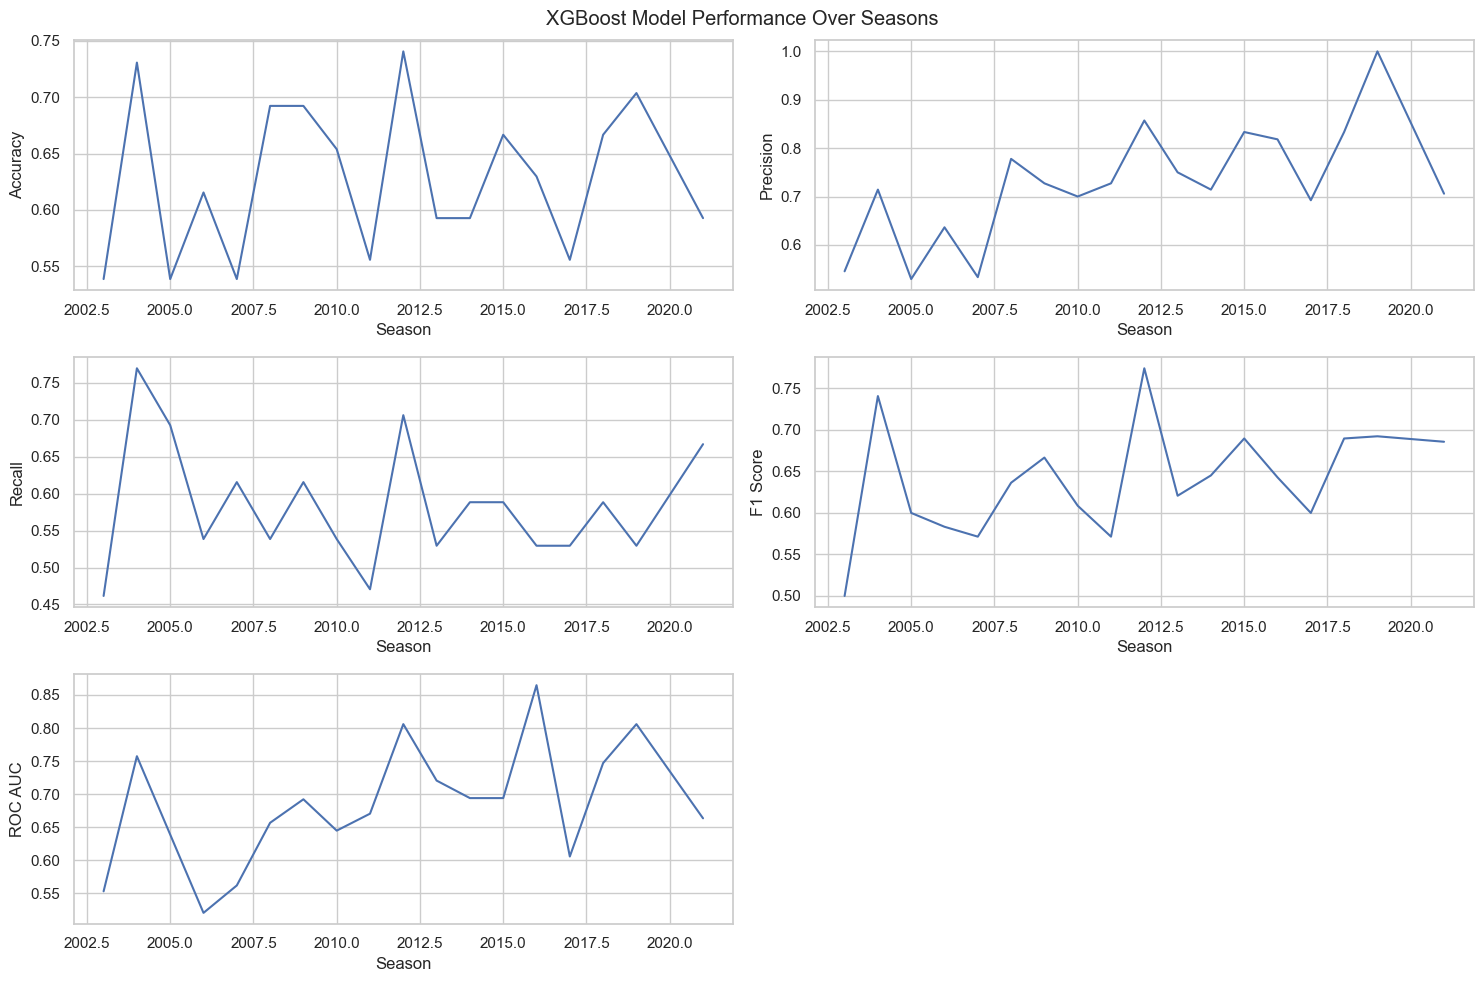

In [54]:
# Set up the matplotlib figure
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('XGBoost Model Performance Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Accuracy', data=xgb_score_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=xgb_score_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=xgb_score_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=xgb_score_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=xgb_score_df, ax=axes[2, 0])

# Hide the empty subplot in the last row and column
axes[2, 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust title position
plt.show()

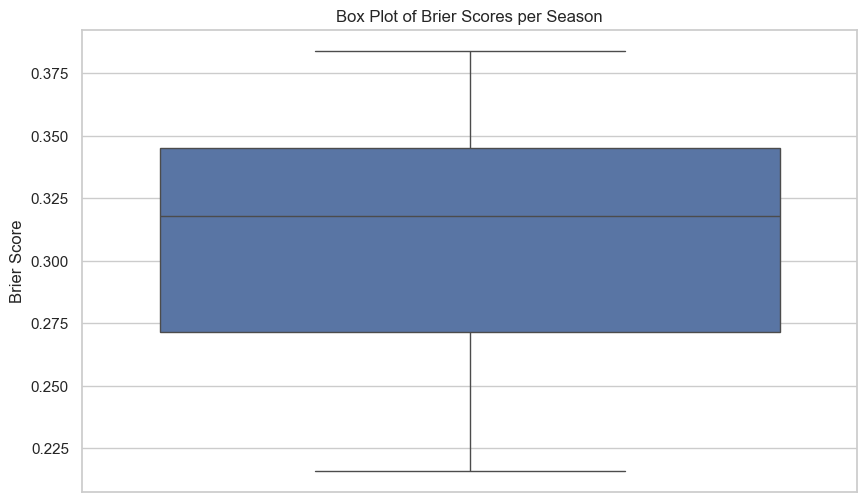

In [55]:
# Create a box plot to visualize the Brier scores
plt.figure(figsize=(10, 6))
sns.boxplot(y='Brier Score', data=xgb_score_df)
plt.title('Box Plot of Brier Scores per Season')
plt.show()

# Model Comparison

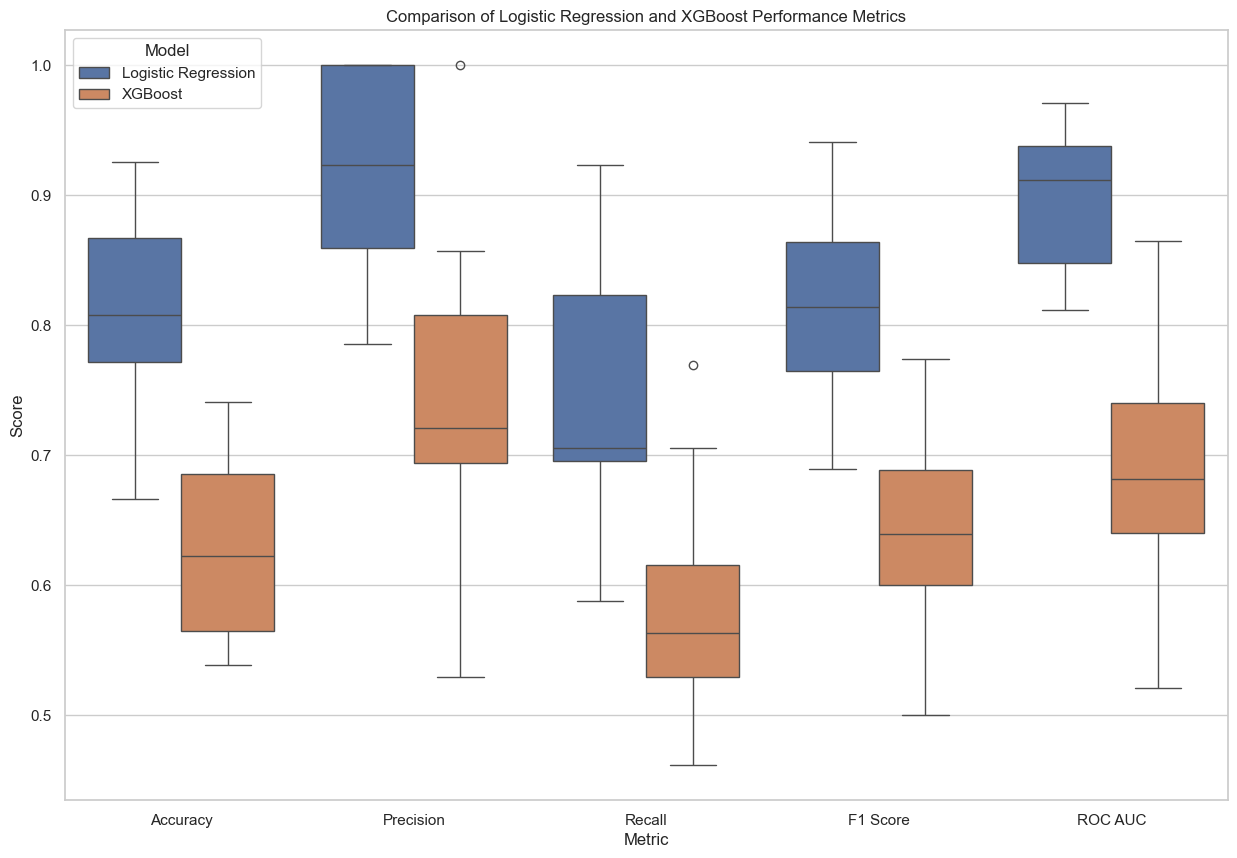

In [56]:
# Melt the dataframes from wide format to long format
log_reg_melted = log_reg_score_df.melt(id_vars=['Season'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                                       var_name='Metric', value_name='Score')
log_reg_melted['Model'] = 'Logistic Regression'

xgb_melted = xgb_score_df.melt(id_vars=['Season'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                               var_name='Metric', value_name='Score')
xgb_melted['Model'] = 'XGBoost'

# Combine the melted dataframes
combined_melted = pd.concat([log_reg_melted, xgb_melted])

# Create the box plots
plt.figure(figsize=(15, 10))
sns.boxplot(x='Metric', y='Score', hue='Model', data=combined_melted)
plt.title('Comparison of Logistic Regression and XGBoost Performance Metrics')
plt.show()


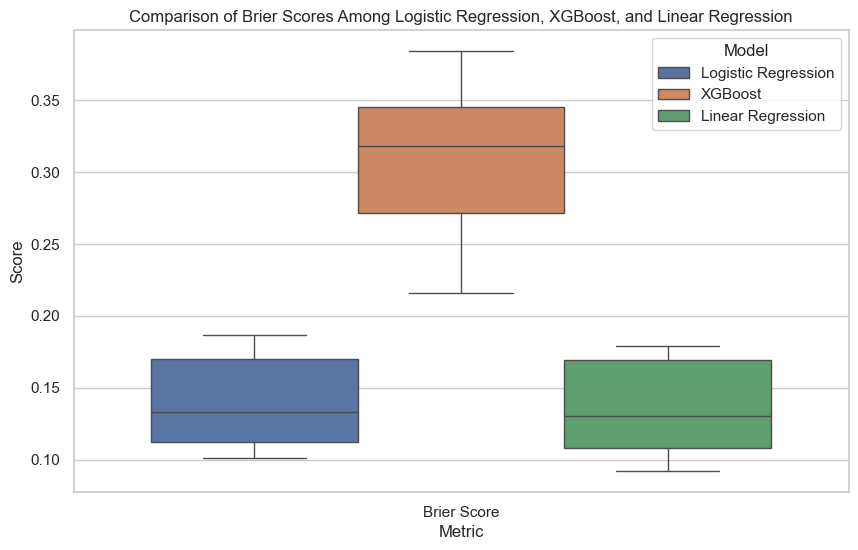

In [57]:
brier_score_column_name = 'Brier Score'  

# Melt the dataframes from wide format to long format
log_reg_melted = log_reg_score_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')
log_reg_melted['Model'] = 'Logistic Regression'

xgb_melted = xgb_score_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                               var_name='Metric', value_name='Score')
xgb_melted['Model'] = 'XGBoost'

lin_reg_melted = error_metrics_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')
lin_reg_melted['Model'] = 'Linear Regression'

# Combine all the melted dataframes
combined_melted = pd.concat([log_reg_melted, xgb_melted, lin_reg_melted])

# Create the box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', hue='Model', data=combined_melted)
plt.title('Comparison of Brier Scores Among Logistic Regression, XGBoost, and Linear Regression')
plt.show()

